https://www.pinecone.io/learn/langchain-intro/

# Load Libraries, Models, & Data

In [1]:
# Install Libraries
!pip install langchain
!pip install openai
!pip install tiktoken
!pip install wordcloud
!pip install faiss-cpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 47.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.0/90.0 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 kB 4.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 kB 2.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 20.6 

In [2]:
# Load Libraries
from langchain import PromptTemplate, LLMChain
from langchain.llms import OpenAI
import os
import pandas as pd
from tqdm import tqdm
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.util import ngrams
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string

from scipy.stats import linregress
import matplotlib.pyplot as plt
import numpy as np

import spacy
import gensim
from gensim.utils import simple_preprocess

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# Load Model
os.environ['OPENAI_API_TOKEN'] = 'sk-'

davinci = OpenAI(model_name='text-davinci-003', openai_api_key= os.environ['OPENAI_API_TOKEN'])
turbo = OpenAI(model_name='gpt-3.5-turbo', openai_api_key= os.environ['OPENAI_API_TOKEN'])

/usr/local/lib/python3.10/dist-packages/langchain/llms/openai.py:171: UserWarning: You are trying to use a chat model. This way of initializing it is no longer supported. Instead, please use: `from langchain.chat_models import ChatOpenAI`
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/langchain/llms/openai.py:716: UserWarning: You are trying to use a chat model. This way of initializing it is no longer supported. Instead, please use: `from langchain.chat_models import ChatOpenAI`
  warnings.warn(


In [3]:
# Load Data
#df = pd.read_csv('complaints-2023-05-07_17_16.csv')
df = pd.read_csv('complaints3.csv')
df2 = df[df['Consumer complaint narrative'].notna()]
print(len(df))
print(len(df2))

3037
3037


# Build Langchain

In [ ]:
template = """Question: {question}

Answer: """
prompt = PromptTemplate(
        template=template,
    input_variables=['question']
)

# user question
question = "What is your confidence level the following complaint poses a compliance risk to the company: 'The user interface is horrible and I hate using it'"

In [ ]:
# Create LangChain
llm_chain = LLMChain(
    prompt=prompt,
    llm=turbo
)

In [ ]:
# Prompt Context & Output Specifications
risks = ['compliance or regulatory', 'technology', 'strategic', 'operational', 'financial']
context1 = '''You are a risk consulting expert.'''

output1 = '''Please output "Yes" or "No", no further explanation needed.'''
output2 = '''Please output "High", "Medium", or "Low", no further explanation needed.'''
output3 = '''Please output a dictionary. for example: Compliance:Yes, Technology:No Strategic:No, Operational:No, Financial:Yes'''
output4 = '''Please output a dictionary. for example: Compliance:High, Technology:Medium Strategic:Low, Operational:Low, Financial:Low'''

output5 = '''Please output a dictionary. for example: Product/Service: Account, Issue: Unauthorized opening'''

In [ ]:
# Binary Yes or No
output = []
questions = [f'''{context1} Does the following complaint pose any compliance, technology,
                  strategic, operational, or financial risk to the company. {output3}''']

# Iterate through data
for i,r in tqdm(df2.iterrows()):
  #print(r['Complaint ID'])
  complaint = r['Consumer complaint narrative']
  qs = [q + complaint for q in questions]
  #print(llm_chain.run(qs))
  output.append(llm_chain.run(qs))

df2['Binary'] = output

In [ ]:
# Determine If binary yes or no
def get_next_letter(text, word='technology'):
    match = re.search(r'{}.*?([a-zA-Z])'.format(word), text)
    next_letter = match.group(1) if match else None
    if next_letter == None:
      return 0
    if next_letter.lower() == 'n':
      return -1
    elif next_letter.lower() == 'y':
      return 1
    else:
      return 0

df2['compliance']  = df2['Binary'].str.lower().apply(lambda x: get_next_letter(x, 'compliance'))
df2['technology']  = df2['Binary'].str.lower().apply(lambda x: get_next_letter(x, 'technology'))
df2['strategic']   = df2['Binary'].str.lower().apply(lambda x: get_next_letter(x, 'strategic'))
df2['operational'] = df2['Binary'].str.lower().apply(lambda x: get_next_letter(x, 'operational'))
df2['financial']   = df2['Binary'].str.lower().apply(lambda x: get_next_letter(x, 'financial'))

In [ ]:
# Trinary High, Medium, or Low
output = []
questions2 = [f'''{context1} What is you confidence level that the following complaint poses any
    compliance, technology, strategic, operational, or financial risk to the company. {output4}''']

# Iterate through data
for i,r in tqdm(df2.iterrows()):
  #print(r['Complaint ID'])
  complaint = r['Consumer complaint narrative']
  qs = [q + complaint for q in questions2]
  output.append(llm_chain.run(qs))

df2['Trinary'] = output

In [ ]:
# Determine High Medium or Low
def get_next_letter(text, word='technology'):
    match = re.search(r'{}.*?([a-zA-Z])'.format(word), text)
    next_letter = match.group(1) if match else None
    if next_letter == None:
      return ''
    if next_letter.lower() == 'h':
      return 'High'
    elif next_letter.lower() == 'm':
      return 'Medium'
    elif next_letter.lower() == 'l':
      return 'Low'
    else:
      return ''

df2['compliance3']  = df2['Trinary'].str.lower().apply(lambda x: get_next_letter(x, 'compliance'))
df2['technology3']  = df2['Trinary'].str.lower().apply(lambda x: get_next_letter(x, 'technology'))
df2['strategic3']   = df2['Trinary'].str.lower().apply(lambda x: get_next_letter(x, 'strategic'))
df2['operational3'] = df2['Trinary'].str.lower().apply(lambda x: get_next_letter(x, 'operational'))
df2['financial3']   = df2['Trinary'].str.lower().apply(lambda x: get_next_letter(x, 'financial'))

In [ ]:
# Topics
output = []
questions2 = [f'''Please help classify the topic of following complaint into a broader category.
For Example: "Unauthorized Transaction" or "Scam"''']

# Iterate through data
for i,r in tqdm(df2.iterrows()):
  #print(r['Complaint ID'])
  complaint = r['Consumer complaint narrative']
  qs = [q + complaint for q in questions2]
  output.append(llm_chain.run(qs))

df2['Summary'] = output

877it [14:08,  1.06s/it]WARNING:langchain.llms.openai:Retrying langchain.llms.openai.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised APIError: Bad gateway. {"error":{"code":502,"message":"Bad gateway.","param":null,"type":"cf_bad_gateway"}} 502 {'error': {'code': 502, 'message': 'Bad gateway.', 'param': None, 'type': 'cf_bad_gateway'}} {'Date': 'Wed, 31 May 2023 01:13:34 GMT', 'Content-Type': 'application/json', 'Content-Length': '84', 'Connection': 'keep-alive', 'X-Frame-Options': 'SAMEORIGIN', 'Referrer-Policy': 'same-origin', 'Cache-Control': 'private, max-age=0, no-store, no-cache, must-revalidate, post-check=0, pre-check=0', 'Expires': 'Thu, 01 Jan 1970 00:00:01 GMT', 'Server': 'cloudflare', 'CF-RAY': '7cfb534e89c84a36-TPE', 'alt-svc': 'h3=":443"; ma=86400'}.
2027it [37:15,  1.09s/it]WARNING:langchain.llms.openai:Retrying langchain.llms.openai.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised APIError: Bad gateway. 

In [ ]:
# Explanation
risks = ['compliance','technology', 'strategic', 'operational', 'financial']

for risk in risks:
  print(risk)
  # Explanation
  tri = risk + '3'
  df3 = df2[(df2[risk]==1) & (df2[tri]=='High')]
  print(len(df3))

  output = []
  questions2 = [f'''{context1} In one sentence or less, briefly explain why the following complaint poses a compliance risk to the company.''']

  # Iterate through data
  for i,r in tqdm(df3.iterrows()):
    #print(r['Complaint ID'])
    complaint = r['Consumer complaint narrative']
    qs = [q + complaint for q in questions2]
    output.append(llm_chain.run(qs))

  df3[risk + '_exp'] = output

  df3.to_csv(risk+'.csv', index=False)

  files.download(risk+'.csv')

# Save Data

In [ ]:
df2.to_csv('complaints3.csv', index=False)

In [ ]:
from google.colab import files
from datetime import datetime

files.download('complaints3.csv')

print(datetime.now())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

2023-05-31 15:59:15.106666


In [ ]:
df2.compliance3.value_counts()

Low       1636
High       697
Medium     693
            11
Name: compliance3, dtype: int64

In [25]:
df = pd.read_csv('complaints3 (1).csv')

# Word Clouds

compliance
1228


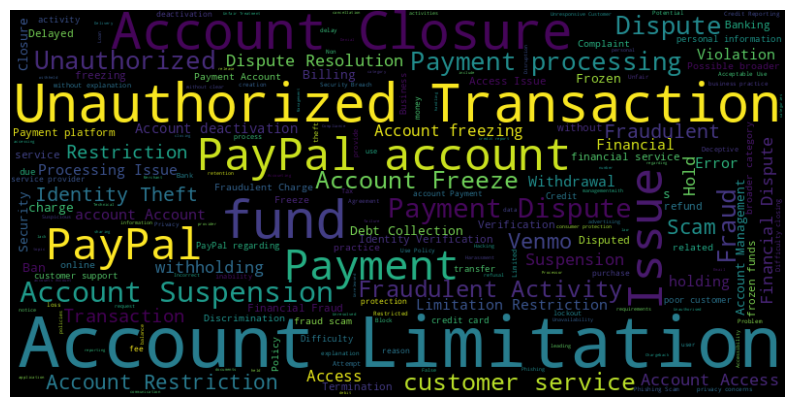

technology
1059


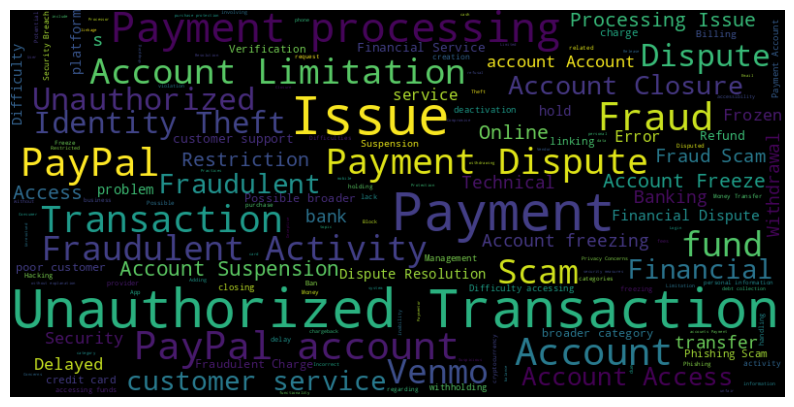

strategic
5


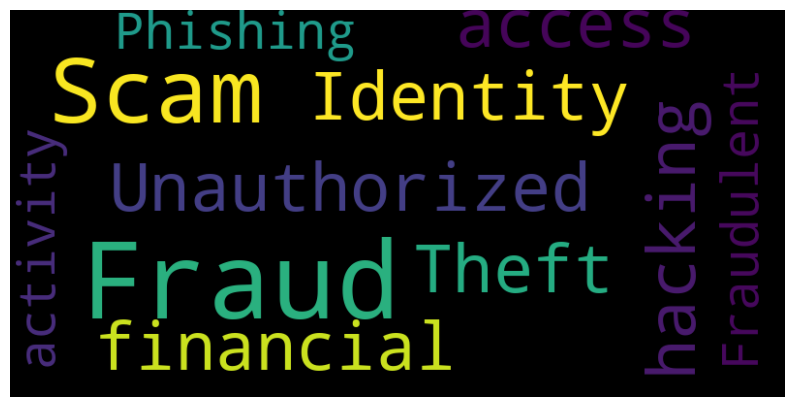

operational
1325


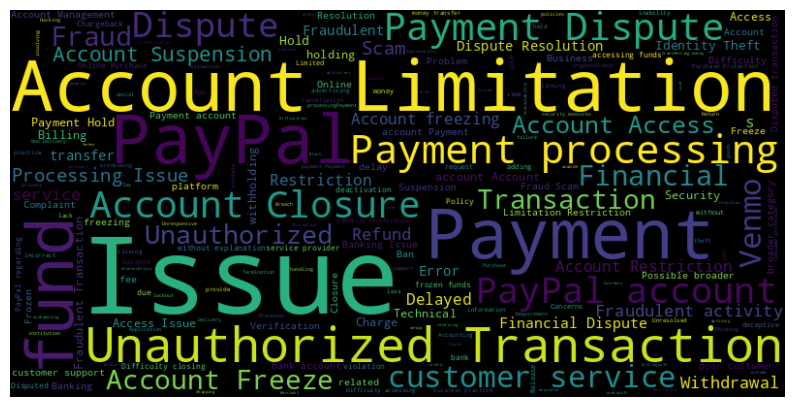

financial
1741


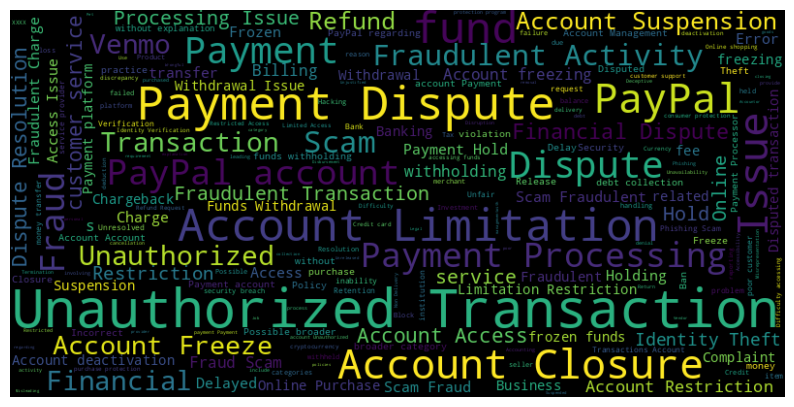

In [26]:
risks = ['compliance', 'technology', 'strategic', 'operational', 'financial']
for risk in risks:
  print(risk)
  df3 = df[(df[risk]==1) & (df[risk+'3'].isin(['High','Medium']))]
  print(len(df3))

  # Concatenate all the text in the 'var1' column into a single string
  text = ' '.join(df3['Summary'])
  for stopword in ['company', 'complaint', 'risk', 'issue', 'poses', 'potential', 'paypal', ' s ', risk]:
    text = text.replace(stopword, '')

  # Generate the word cloud
  wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110).generate(text)

  # Plot the word cloud
  plt.figure(figsize=(10, 7))
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.axis('off')
  plt.title = risk
  plt.show()

# Trends

In [27]:
df['Date received'] = pd.to_datetime(df['Date received'])
df.set_index('Date received', inplace=True)

df = df[df.index <= '2023-02-28']

In [28]:
# Remove punctuation and make lowercase
df['clean_text'] = df['Summary'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)).lower())

# Tokenize the text
df['tokens'] = df['clean_text'].apply(nltk.word_tokenize)

# Remove stop words
stop_words = set(stopwords.words('english'))
df['tokens'] = df['tokens'].apply(lambda tokens: [token for token in tokens if token not in stop_words])

# Lemmatize the tokens
lemmatizer = WordNetLemmatizer()
df['tokens'] = df['tokens'].apply(lambda tokens: [lemmatizer.lemmatize(token) for token in tokens])

# Generate n-grams of lengths 1, 2, and 3
df['n_grams'] = df['tokens'].apply(lambda tokens: list(ngrams(tokens, 1)) + list(ngrams(tokens, 2)) + list(ngrams(tokens, 3)))

# Get all n-grams in the dataset
all_n_grams = [n_gram for n_grams in df['n_grams'] for n_gram in n_grams]

# Count the frequency of each n-gram
ngram_freq = Counter(all_n_grams)

# Keep only n-grams that appear more than 10 times
ngram_freq = {k: v for k, v in ngram_freq.items() if v > 18}

n_gram_list = []
# For each n-gram, create a column in the original dataframe indicating whether the n-gram is present
for n_gram in ngram_freq.keys():
    n_gram_str = ' '.join(n_gram)
    n_gram_list.append(n_gram_str)
    df[n_gram_str] = df['n_grams'].apply(lambda n_grams: int(n_gram in n_grams))

<ipython-input-28-5c33188ecc6e>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[n_gram_str] = df['n_grams'].apply(lambda n_grams: int(n_gram in n_grams))
<ipython-input-28-5c33188ecc6e>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[n_gram_str] = df['n_grams'].apply(lambda n_grams: int(n_gram in n_grams))
<ipython-input-28-5c33188ecc6e>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at o

compliance
2098


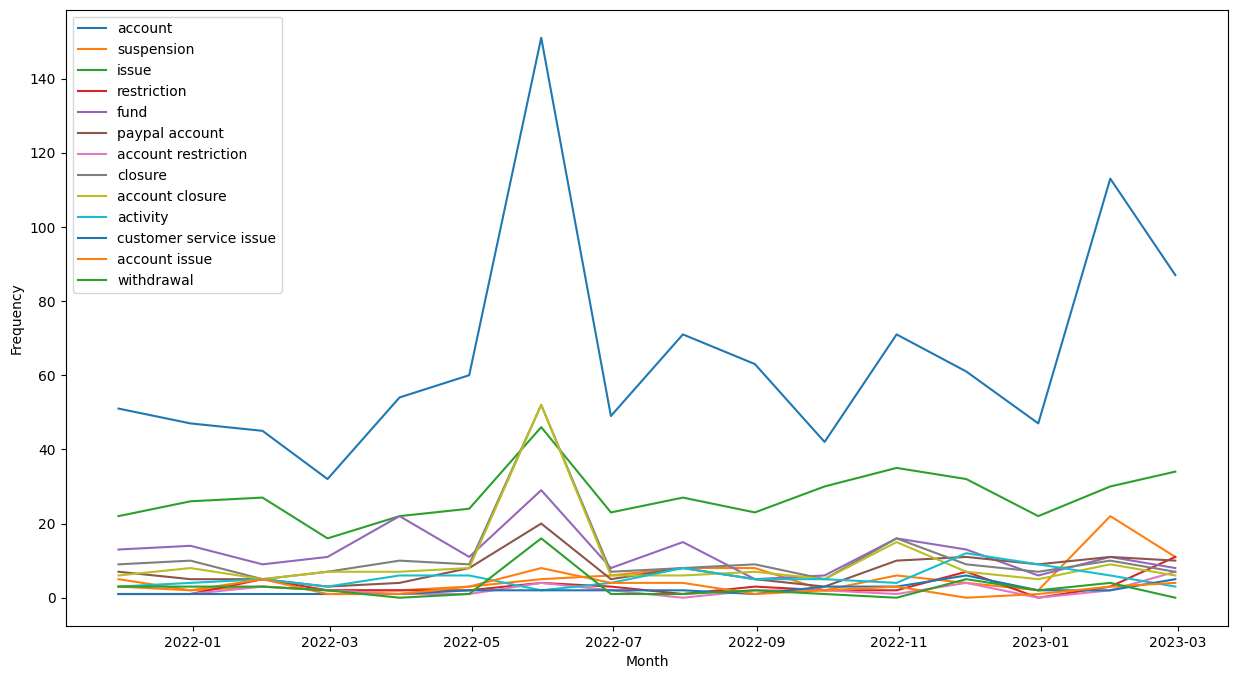

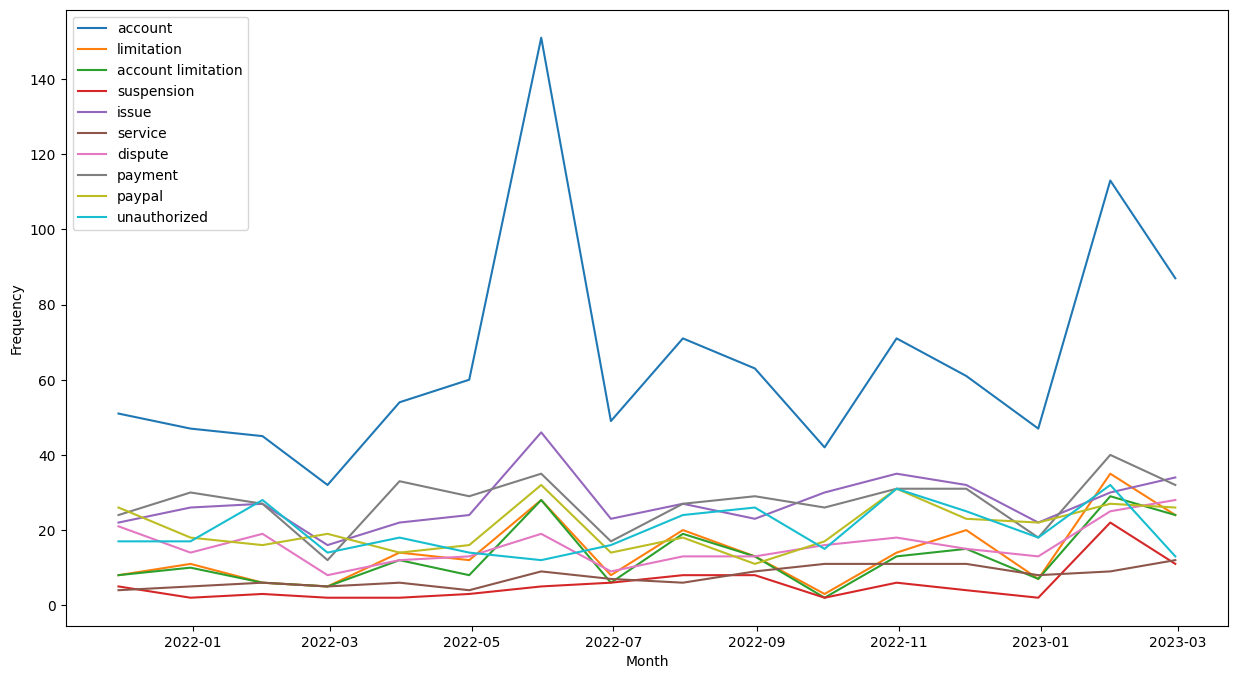

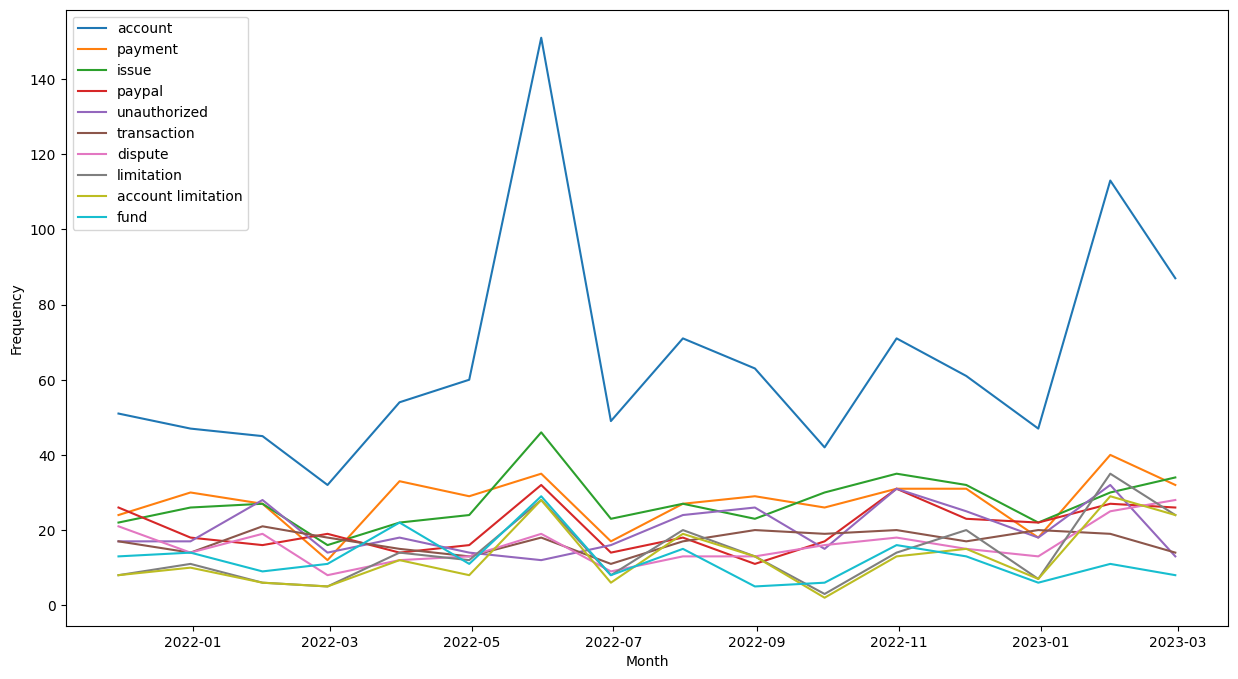

technology
1408


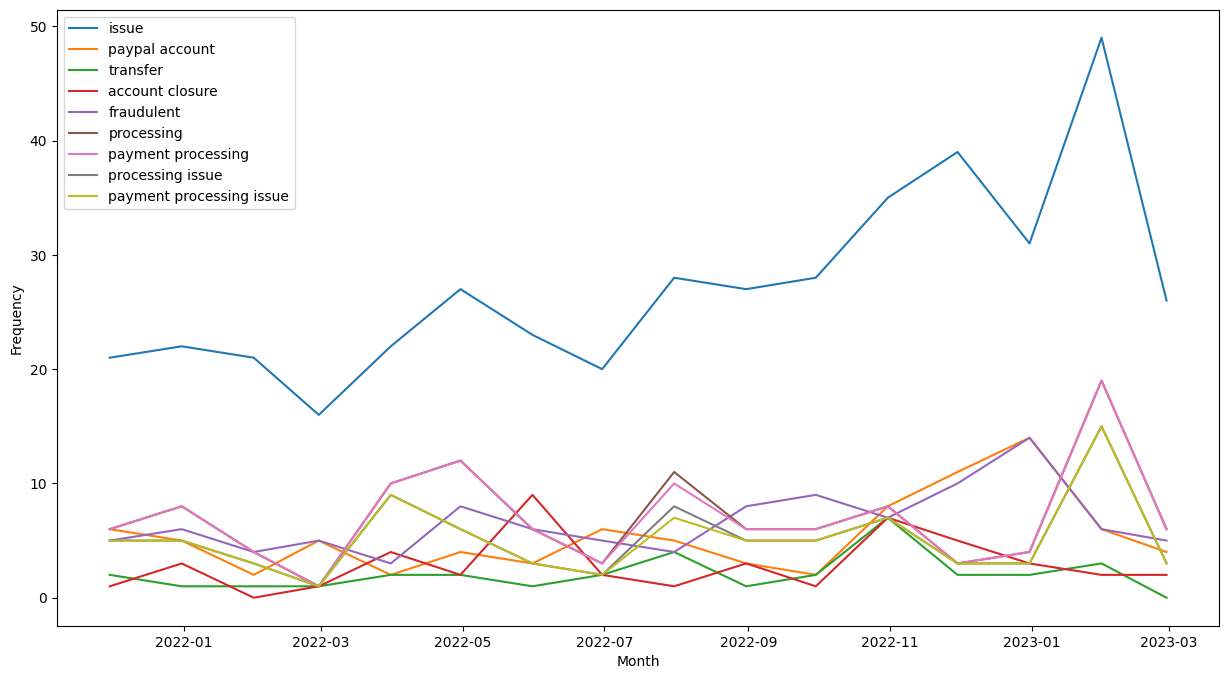

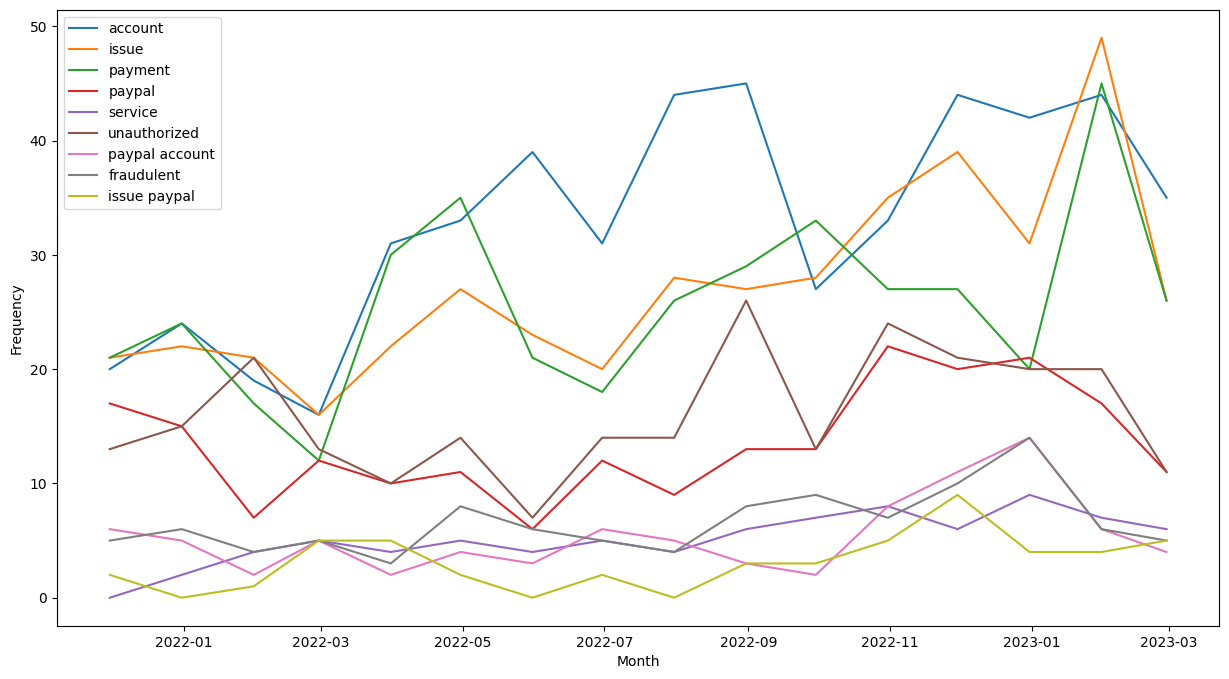

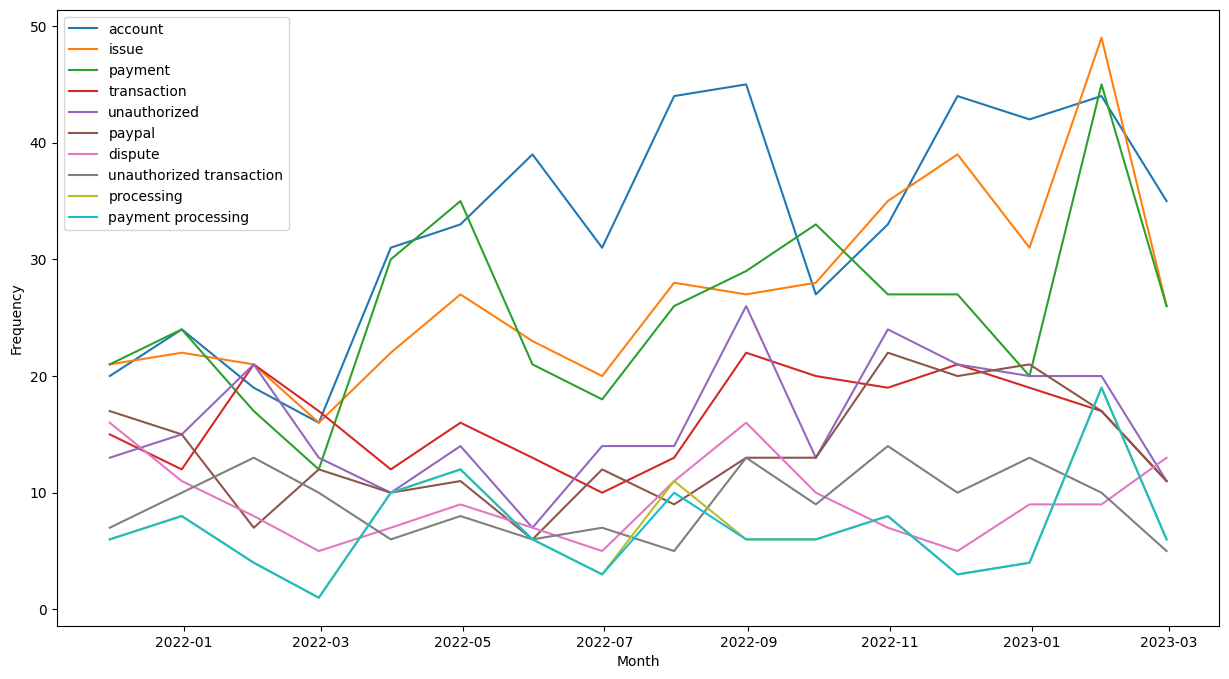

strategic
38
operational
1873


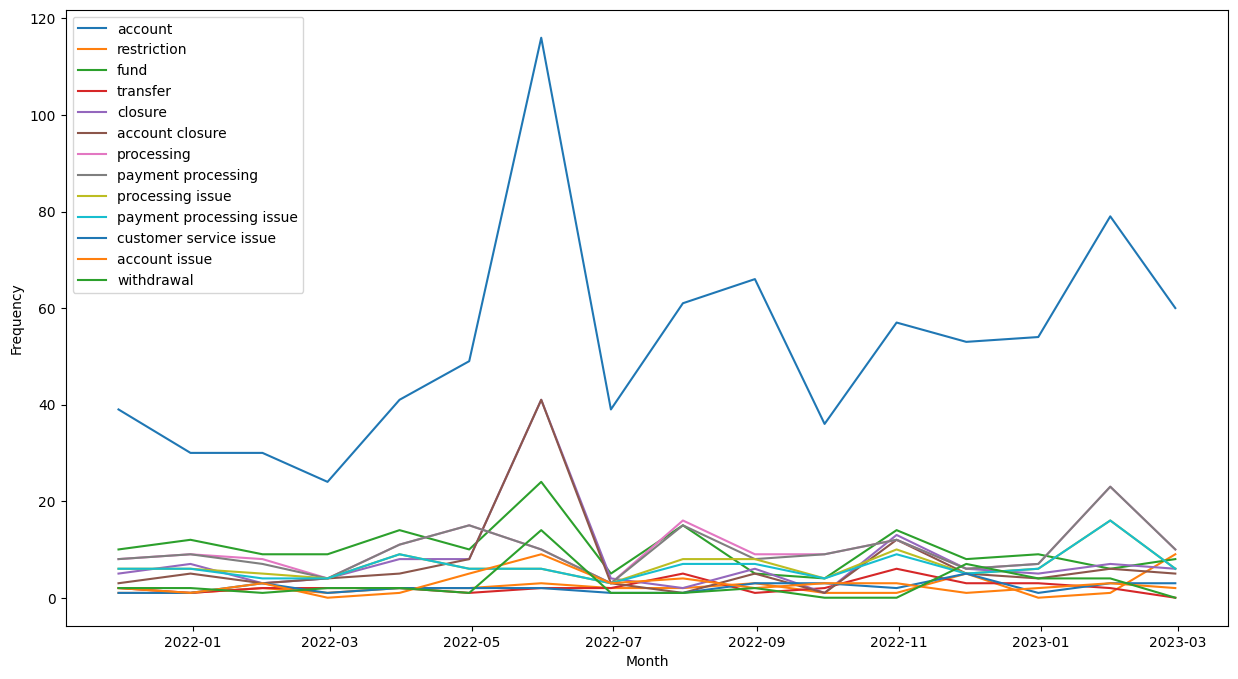

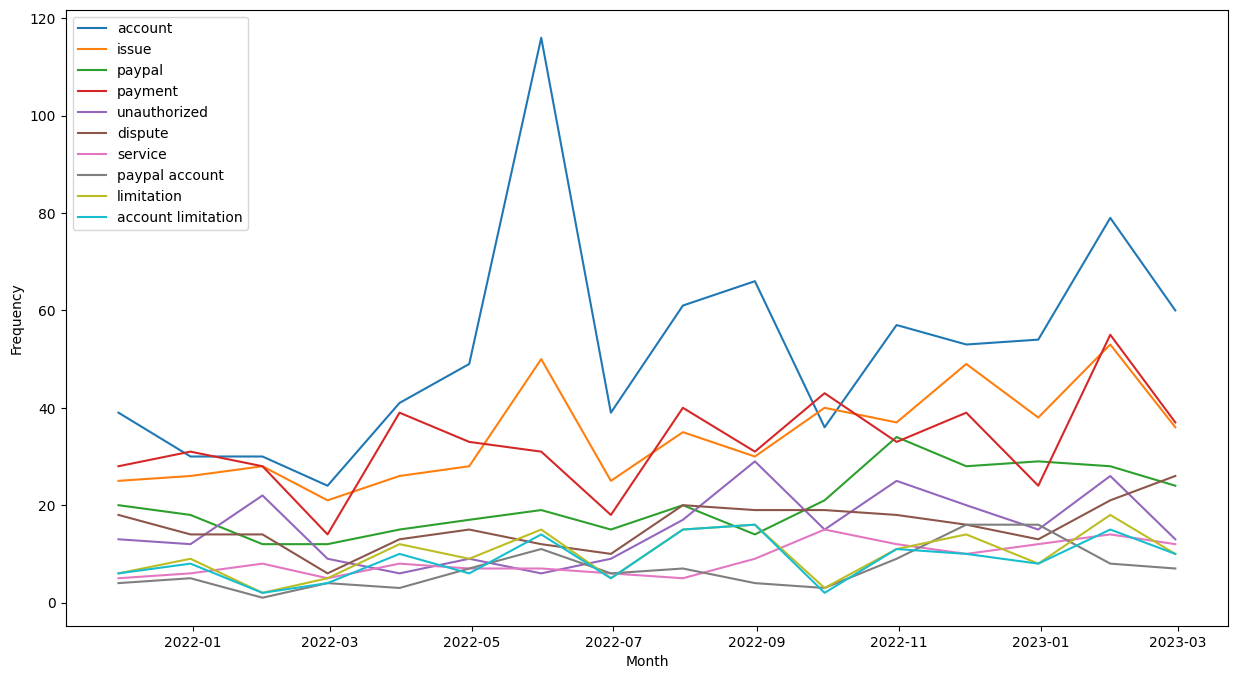

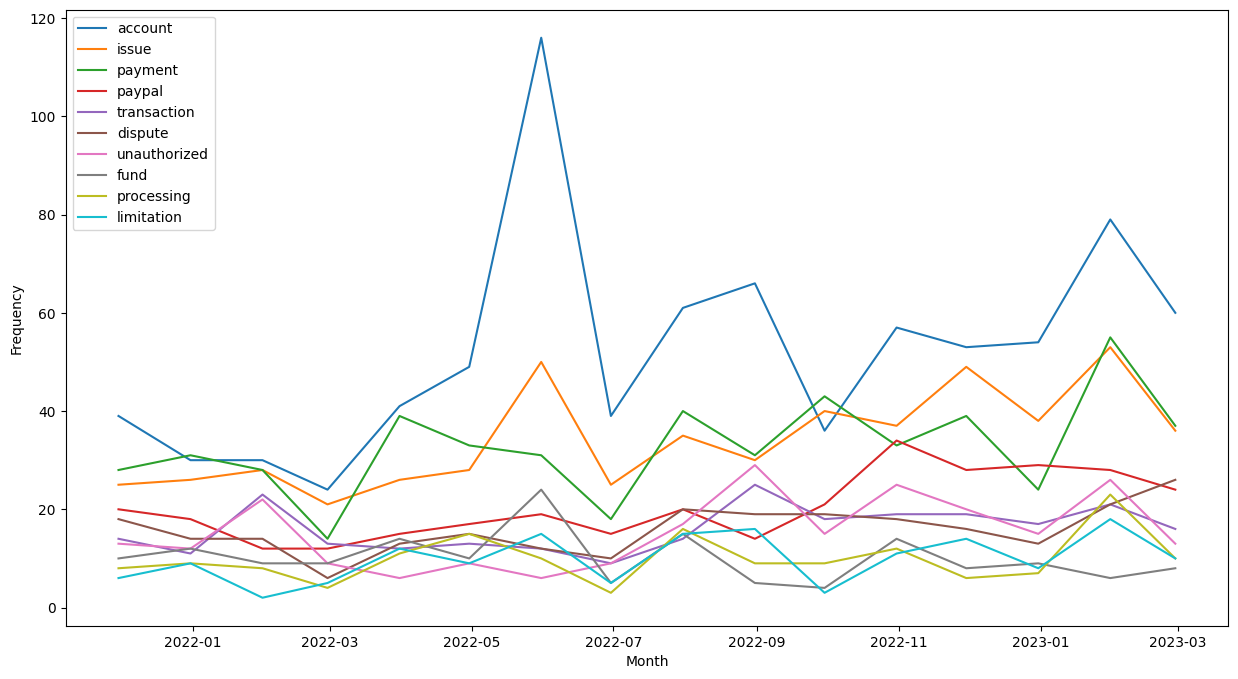

financial
144


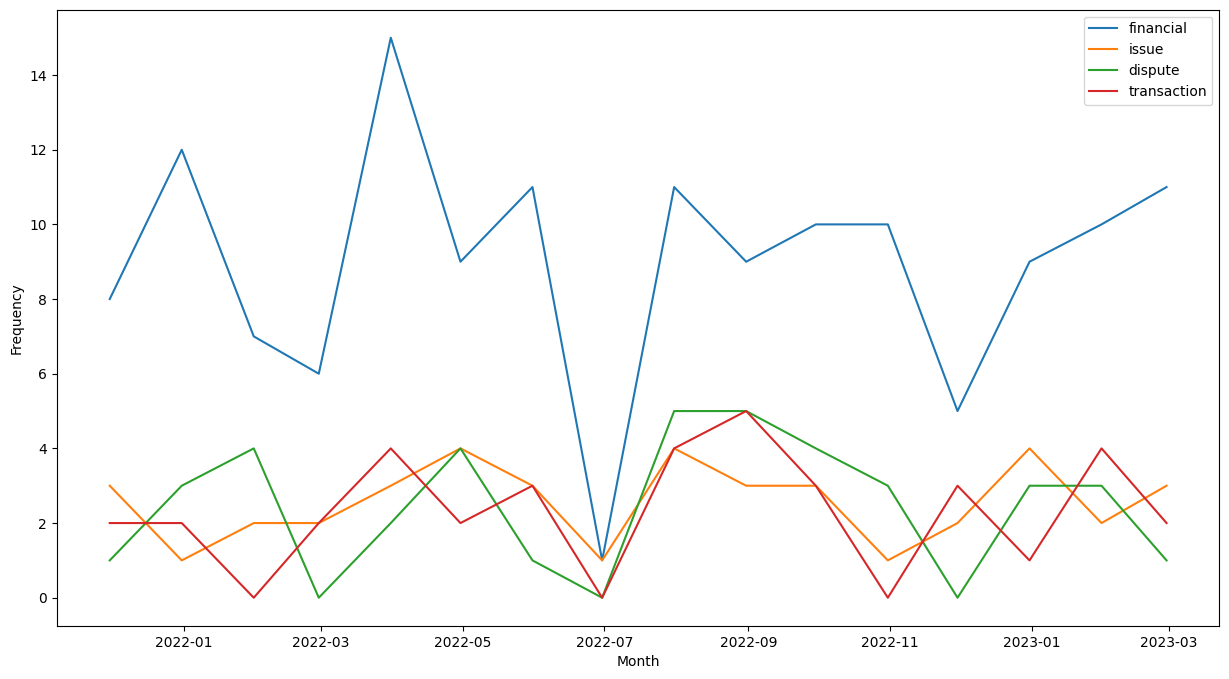

In [33]:
risks = ['compliance', 'technology', 'strategic', 'operational', 'financial']

for risk in risks:
  print(risk)
  temp = df[(df[risk]==1) & (df[risk+'3'].isin(['High','Medium']))]
  temp = df[(df[risk]==1) ]
  print(len(temp))

  # For each n-gram, create a column in the original dataframe indicating whether the n-gram is present
  # Then, resample by month and calculate the sum
  monthly_data = {}

  for n_gram_str in n_gram_list:
      monthly_sum = temp[n_gram_str].resample('M').sum()
      # Keep only n-grams that have a monthly average greater than 2
      if monthly_sum.mean() > 2:
        monthly_data[n_gram_str] = monthly_sum

  # Combine all the monthly data into a single DataFrame
  monthly_df = pd.DataFrame(monthly_data)

  # Calculate the monthly average and standard deviation for each n-gram
  avg = monthly_df.mean()
  std = monthly_df.std()


  ### 3 STANDARD DEVIATIONS
  thresh = 2.5

  # Identify which n-grams have at least one month that's 2 standard deviations away from the average
  significant_ngrams = [n_gram for n_gram in monthly_df.columns if any((monthly_df[n_gram] > avg[n_gram] + thresh*std[n_gram]) | (monthly_df[n_gram] < avg[n_gram] - thresh*std[n_gram]))]

  # Plot these n-grams
  if len(significant_ngrams)>0:
    plt.figure(figsize=(15,8))
    for n_gram in significant_ngrams:
        plt.plot(monthly_df.index, monthly_df[n_gram], label=n_gram)
    plt.xlabel('Month')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()


  ### TOP 10 INCREASING

  # Calculate the slope for each n-gram
  slopes = {}
  for n_gram in monthly_df.columns:
      slope, _, _, _, _ = linregress(np.arange(len(monthly_df)), monthly_df[n_gram])
      if slope > 0.25:
          slopes[n_gram] = slope

  # Sort the n-grams by slope in descending order and select the top 10
  top_ngrams = sorted(slopes, key=slopes.get, reverse=True)[:10]

  # Plot these n-grams
  if len(top_ngrams)>0:
    plt.figure(figsize=(15,8))
    for n_gram in top_ngrams:
        plt.plot(monthly_df.index, monthly_df[n_gram], label=n_gram)
    plt.xlabel('Month')
    plt.ylabel('Frequency')
    #plt.title('Monthly trends for top 10 n-grams with largest positive slopes')
    plt.legend()
    plt.show()

  ### Top 10 popular
  populars = monthly_df.sum(axis=0).sort_values(ascending=False).index[:10]

  # Plot these n-grams
  if len(populars)>0:
    plt.figure(figsize=(15,8))
    for n_gram in populars:
        plt.plot(monthly_df.index, monthly_df[n_gram], label=n_gram)
    plt.xlabel('Month')
    plt.ylabel('Frequency')
    #plt.title('Monthly trends for top 10 n-grams with largest positive slopes')
    plt.legend()
    plt.show()

In [ ]:
pd.crosstab(df['compliance'], df['compliance3'])

compliance3,High,Low,Medium
compliance,,,
-1,53,747,100
0,3,8,6
1,641,881,587


In [32]:
monthly_df.sum(axis=0).sort_values(ascending=False).index[:10]

Index(['financial', 'issue', 'dispute', 'transaction'], dtype='object')

# Search

In [ ]:
pages = df2['Consumer complaint narrative']

In [ ]:
from langchain.vectorstores import FAISS
from langchain.embeddings.openai import OpenAIEmbeddings

faiss_index = FAISS.from_texts(pages, OpenAIEmbeddings(openai_api_key= os.environ['OPENAI_API_TOKEN']))

In [ ]:
docs = faiss_index.similarity_search("regulatory risk", k=3)
for doc in docs:
  print(doc.page_content + "/n/n")

On XX/XX/2021, PayPal permanently limited the account of a household member. To my surprise, I just logged in to my account today and found that they have permanently limited my account too due to " Potential Risk ''. This's retaliatory action, being a member from the same household doesn't give you the right to shut down my account too. Please indicate what activity did you determine as " Potential Risk ''? My PayPal account history and activities are flawless, with no fraudulent or chargeback transactions ever. I had my account for so many years without any issues. Is it legal to shut down my account because of another household member being unfairly shut down? Please don't reply with nonsense Terms & Conditions. The last activity in my account was on XX/XX/2021, you didn't shut down my account UNTIL you shut down the other member 's account as a retaliatory action./n/n
I had an account with Paypal since 2016 and my account was permanently limited due to unknown reasons. I contacted 

In [ ]:
faiss_index.save_local('faiss')

In [ ]:
test = FAISS.load_local("faiss", OpenAIEmbeddings)

In [ ]:
docs = faiss_index.similarity_search("illegal", k=3)
for doc in docs:
  print(doc.page_content + "/n/n")

It occurred without my knowledge, approval/n/n
I was in jail and XXXX again collecting the money for me I can provide proof of the fact that I have been in jail in XXXX XXXX Florida Pay Pal allowed use of my credit card and then grave him my money from arritration for violation of copyright./n/n
PayPal illegally froze my account and flat out refuses to unblock my account/n/n
